In [1]:
import pandas as pd
from geopy.distance import distance
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Вместимость одного узла определяется как доля от общего веса всех видео
STORAGE_SIZE_SHARE = 0.05
# Для определения задержки между узлами посчитаем расстояние между ними и умножим на некоторую константу
LATENCY_PER_KM = 0.0048
NETWORK_FACTOR = 1.7
DATA_PROCESSING_MS = 0.
# Вес, который определяет баланс важность между длиной и популярностью видео. Чем больше тем длина важнее. Принимает значение в отрезке [0; 1]
LENGTH_POPULARITY_COEF = 0.5

Функция для расчета задержки между двумя узлами. Используются константы определенные ранее

In [3]:
# point -> (lat, lon)
def get_latency(point1, point2):
    return round(distance(point1, point2).km * LATENCY_PER_KM * NETWORK_FACTOR + DATA_PROCESSING_MS, 2)

Загружаем граф, задаем веса ребрам и сохраняем кратчайшие пути между узлами

In [4]:
G = nx.read_gml("topology.gml")

# Сервер, который содержит все видео, а также все узлы сети обращаются к нему в самом начале
ORIGIN_SERVER = "DLLS"

# Задаем веса всем ребрам графа - задержки между узлами сети
for A_label, B_label in G.edges:
    A = G.nodes[A_label]
    B = G.nodes[B_label]
    G[A_label][B_label]['weight'] = get_latency((A['Latitude'], A['Longitude']), (B['Latitude'], B['Longitude']))
    print(f"{A_label} <- {G[A_label][B_label]['weight']} -> {B_label}")


# Определяем кратчайшие пути между всеми узлами и длину этих путей
fast_path = {}
fast_path_length = {}
for src, (lengths, paths) in nx.all_pairs_dijkstra(G):
    fast_path[src] = {}
    for dst, path in paths.items():
        fast_path[src][dst] = path

    fast_path_length[src] = {}
    for dst, length in lengths.items():
        fast_path_length[src][dst] = length

nodes = list(G.nodes)
nodes.remove(ORIGIN_SERVER)

NY54 <- 2.48 -> CMBR
NY54 <- 9.37 -> CHCG
NY54 <- 1.06 -> PHLA
NY54 <- 2.68 -> WASH
CMBR <- 3.54 -> PHLA
CHCG <- 4.06 -> CLEV
CHCG <- 8.75 -> PHLA
CHCG <- 3.41 -> STLS
CHCG <- 12.07 -> DNVR
CHCG <- 5.42 -> KSCY
CHCG <- 24.4 -> SNFN
CHCG <- 22.81 -> STTL
CHCG <- 16.54 -> SLKC
CLEV <- 6.03 -> NSVL
CLEV <- 6.46 -> STLS
CLEV <- 4.71 -> PHLA
RLGH <- 4.67 -> ATLN
RLGH <- 3.06 -> WASH
ATLN <- 7.12 -> WASH
ATLN <- 2.82 -> NSVL
ATLN <- 6.14 -> STLS
ATLN <- 9.48 -> DLLS
ATLN <- 5.26 -> ORLD
PHLA <- 1.63 -> WASH
NSVL <- 3.32 -> STLS
NSVL <- 8.11 -> DLLS
STLS <- 7.19 -> DLLS
STLS <- 3.17 -> KSCY
STLS <- 20.87 -> LA03
NWOR <- 4.17 -> HSTN
NWOR <- 5.82 -> DLLS
NWOR <- 7.01 -> ORLD
HSTN <- 2.49 -> SNAN
HSTN <- 2.95 -> DLLS
HSTN <- 11.15 -> ORLD
SNAN <- 11.14 -> PHNX
SNAN <- 3.31 -> DLLS
DLLS <- 8.69 -> DNVR
DLLS <- 5.95 -> KSCY
DLLS <- 19.48 -> SNFN
DLLS <- 16.28 -> LA03
DNVR <- 7.29 -> KSCY
DNVR <- 12.47 -> SNFN
DNVR <- 4.88 -> SLKC
KSCY <- 19.76 -> SNFN
SNFN <- 0.99 -> SCRM
SNFN <- 7.02 -> PTLD
SNF

Загружаем датасет с городами и определяем средневзвешенную по численности населения задержку между абстрактным клиентом и узлом. Необходимо для того, чтобы увеличить важность тех узлов, клиенты которого испытывают большую задержку

In [5]:
cities = pd.read_csv("uscities.csv")

# Для каждого города определяем ближайший узел сети
node_cities = {i: [] for i in nodes}
i = 1
for city in cities.iloc:
    point1 = (city["lat"], city["lng"])
    population = city["population"]
    min_latency = -1
    min_node = ""
    for target_node in nodes:
        point2 = (G.nodes[target_node]['Latitude'], G.nodes[target_node]['Longitude'])
        latency = get_latency(point1, point2)
        if min_latency == -1 or latency < min_latency:
            min_latency = latency
            min_node = target_node
    node_cities[min_node].append((min_latency, population))
    print(f"\r{i}/{cities.shape[0]}", end='')
    i += 1

# Считаем средневзвешенную по численности населения задержку от абстрактного клиента до узла
node_city_latency = {}
for target_node, values in node_cities.items():
    pop_lat = 0
    sum_pop = 0
    for lat, pop in values:
        pop_lat += pop * lat
        sum_pop += pop
    node_city_latency[target_node] = round(pop_lat / sum_pop, 2)

node_city_latency

28338/28338

{'NY54': 0.32,
 'CMBR': 0.55,
 'CHCG': 1.72,
 'CLEV': 1.55,
 'RLGH': 1.45,
 'ATLN': 1.11,
 'PHLA': 0.42,
 'WASH': 0.62,
 'NSVL': 1.59,
 'STLS': 1.11,
 'NWOR': 1.35,
 'HSTN': 1.92,
 'SNAN': 1.77,
 'ORLD': 2.41,
 'DNVR': 1.33,
 'KSCY': 2.41,
 'SNFN': 4.2,
 'SCRM': 0.83,
 'PTLD': 0.79,
 'STTL': 1.94,
 'SLKC': 1.44,
 'LA03': 0.68,
 'SNDG': 0.45,
 'PHNX': 1.32}

Загружаем датасет с видео, определяем популярность видео в виде доли просмотров от общего числа, определяем ограничение по размеру хранилища узла

In [6]:
videos = pd.read_csv("videos.csv")
# Чтобы не работало долго берем небольшую выборку
videos = videos.sample(200)
videos["popularity"] = videos["view_count"] / videos["view_count"].sum()

# Размер хранилища узла определяется как доля от суммарного размера видео в датасете
NODE_STORAGE_SIZE = int(videos["video_size"].sum() * STORAGE_SIZE_SHARE)

Определяем данные, которые алгоритм будет изменять в процессе работы

In [7]:
# Текущее свободное место в каждом узле
node_capacity = {}
# Текущая задержка на каждом узле: задержка от абстрактного клиента до узла + средневзвешенная по популярности задержка для получения видео
node_latency = {}
# Словарь со средневзвешенными задержками, где весами является важность видео. Важность видео определяется в зависимости от требований. Используется в алгоритме
node_with_space_latency = {}
# Ближайший к текущему узлу узел содержащий копию видео
node_video_closest_server = {}
# Список видео содержащихся на узле
node_videos = {}
# Столбец значения которого определяют важность видео
# Значения в данном столбце лежат в [0; 1] причем сумма всего столбца равна 1
IMPORTANCE = "popularity"


# Обнуляем данные размещения используя выбранный столбец важности видео
def reset_placement(importance):
    global node_capacity, node_latency, node_with_space_latency, node_video_closest_server, node_videos
    node_capacity = {node: NODE_STORAGE_SIZE for node in nodes}
    node_video_closest_server = {node: {} for node in nodes}
    node_videos = {node: [] for node in nodes}
    # Изначально заполняется только задержка от абстрактного клиента до узла
    node_latency = {node: node_city_latency[node] for node in nodes}
    node_with_space_latency = node_latency.copy()
    # Прибавляем средневзвешенную по популярности задержку для получения видео
    i = 0
    for target_node in nodes:
        j = 1
        for video in videos.iloc:
            node_latency[target_node] += fast_path_length[target_node][ORIGIN_SERVER] * video["popularity"]
            node_with_space_latency[target_node] += fast_path_length[target_node][ORIGIN_SERVER] * video[importance]
            node_video_closest_server[target_node][video["video_id"]] = ORIGIN_SERVER
            # print(f"\r{j + i * videos.shape[0]}/{videos.shape[0] * len(nodes)}", end='')
            j += 1
        i += 1


reset_placement(IMPORTANCE)
no_placement = node_latency.copy()

Простой алгоритм распределения видео по узлам сети. На каждой итерации выбирается узел, клиенты которого испытывают наибольшую задержку. Для него выбирается видео, которое наилучшим образом уменьшает задержку. Выбранное видео размещается на выбранном узле, а также данные о задержке обновляются на тех узлах, которые выигрывают от этого размещения

In [8]:
def place_videos_v1(importance):
    global node_capacity, node_latency, node_with_space_latency, node_video_closest_server, node_videos
    while node_with_space_latency:
        # Выбираем узел с наибольшей задержкой
        target_node = max(node_with_space_latency, key=node_with_space_latency.get)

        # Убираем из поиска все видео размер которых превышает текущее свободное место на узле и которые уже есть на сервере
        target_videos = videos[(videos["video_size"] <= node_capacity[target_node]) & (~videos["video_id"].isin(node_videos[target_node]))]
        # Если нет видео которые можно разместить тогда убираем из рассмотрения данный узел
        if target_videos.shape[0] == 0:
            node_with_space_latency.pop(target_node)
            continue

        # Ищем видео, добавление которого на узел наилучшим образом улучшит задержку
        max_video_latency = 0
        target_video = None
        for video in target_videos.iloc:
            video_node = node_video_closest_server[target_node][video["video_id"]]
            cur_latency = fast_path_length[target_node][video_node] * video[importance]
            if cur_latency > max_video_latency:
                max_video_latency = cur_latency
                target_video = video

        for node in nodes:
            # Определяем будет ли улучшение для узла от размещения видео на выбранном узле
            cur_video_node = node_video_closest_server[node][target_video["video_id"]]
            cur_latency = fast_path_length[node][cur_video_node]
            new_latency = fast_path_length[node][target_node]
            if cur_latency < new_latency:
                continue

            # Обновляем задержку и меняем узел, с которого данное видео будет запрашиваться
            # Обычная задержка всегда подсчитывается с использованием популярности
            node_latency[node] -= (cur_latency - new_latency) * target_video["popularity"]
            node_video_closest_server[node][target_video["video_id"]] = target_node
            if node in node_with_space_latency:
                node_with_space_latency[node] -= (cur_latency - new_latency) * target_video[importance]
        # Добавляем видео на узел и уменьшаем свободное место
        node_videos[target_node].append(target_video["video_id"])
        node_capacity[target_node] -= target_video["video_size"]

Проводим первое размещение и сохраняем его результаты

In [9]:
place_videos_v1(IMPORTANCE)
first_placement = node_latency.copy()

Оценим насколько улучшилась задержка после размещения видео

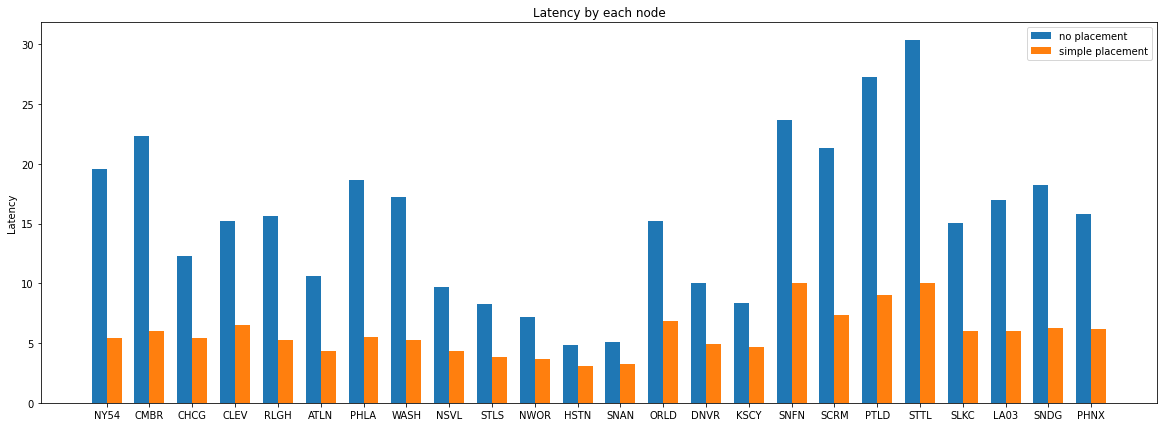

In [10]:
def compare_placement(first, second, label1, label2):
    arr1 = []
    arr2 = []
    for node in nodes:
        arr1.append(first[node])
        arr2.append(second[node])

    x = np.arange(len(nodes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(20, 7))
    rects1 = ax.bar(x - width/2, arr1, width, label=label1)
    rects2 = ax.bar(x + width/2, arr2, width, label=label2)

    ax.set_ylabel('Latency')
    ax.set_title('Latency by each node')
    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.legend()
    plt.show()

compare_placement(no_placement, first_placement, 'no placement', 'simple placement')

In [11]:
def count_videos_without_replicas():
    videos_without_replica = 0
    for video in videos["video_id"]:
        k = 0
        for v in node_videos.values():
            if video not in v:
                k += 1
        if k != len(node_videos):
            videos_without_replica += 1
    return videos_without_replica

print(f"Видео, которые присутствуют только на оригинальном сервере: {count_videos_without_replicas()}/{videos.shape[0]}")

Видео, которые присутствуют только на оригинальном сервере: 67/200


Как можно заметить некоторое количество видео осталось без реплики, что означает, что они будут получаться с оригинального сервера. Очевидно, что в таком случае оригинальный сервер должен быть значительно производительнее, несмотря на то, что в силу специфики алгоритма размещения данные видео будут наименее популярны, а следовательно будут вносить меньший вклад в нагрузку на сервер

Теперь применим показатель длины в алгоритме. Для начала взглянем на нашу выборку.

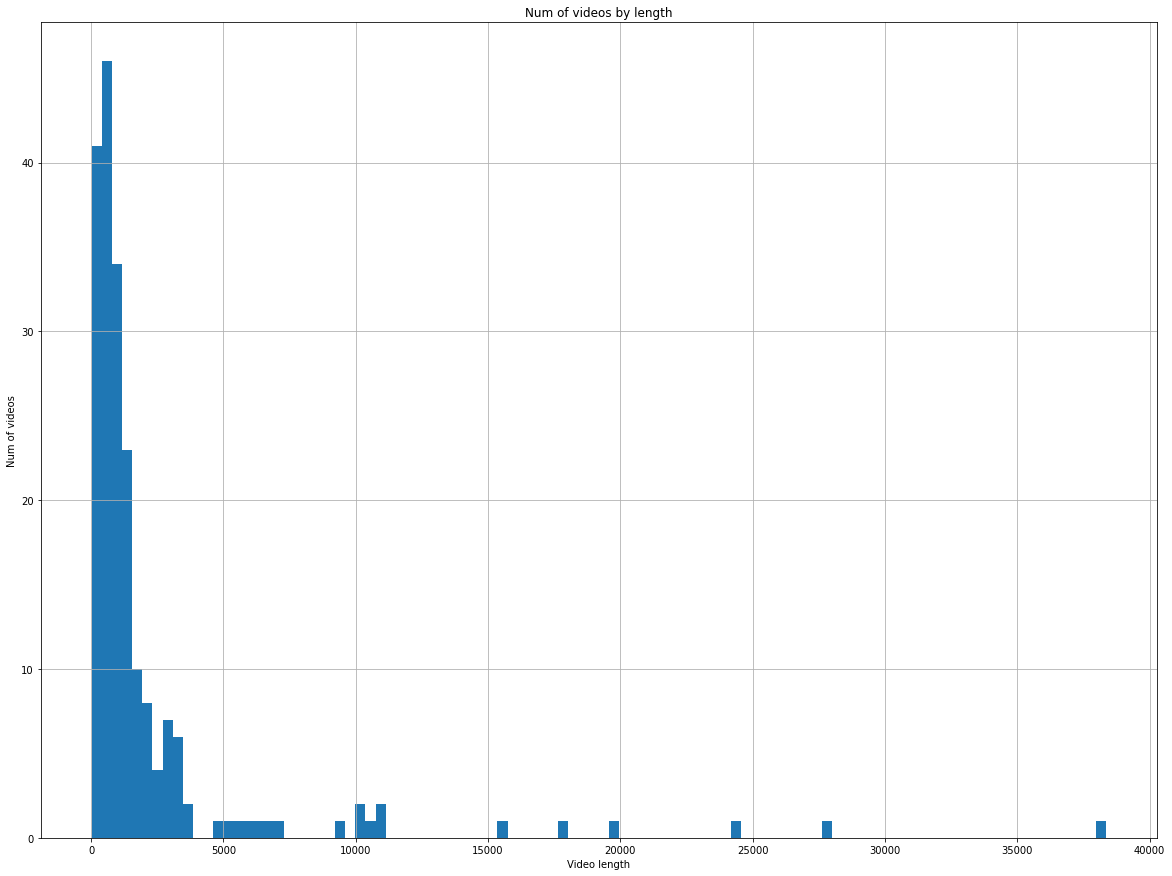

In [12]:
ax = plt.figure(figsize=(20,15)).gca()
ax.set_xlabel("Video length")
ax.set_ylabel("Num of videos")
ax.set_title('Num of videos by length')
videos["video_length"].hist(ax=ax, bins=100)
plt.show()

Как можно видеть короткие видео преобладают. Далее разделим всю выборку на 10 групп по квантилям, по каждой из которых мы определим максимальную и среднюю задержку

In [13]:
# Разделим все видео на 10 групп относительно длины по квантилям
videos["video_length_group"] = pd.qcut(videos["video_length"], 10, labels=list(range(10)))

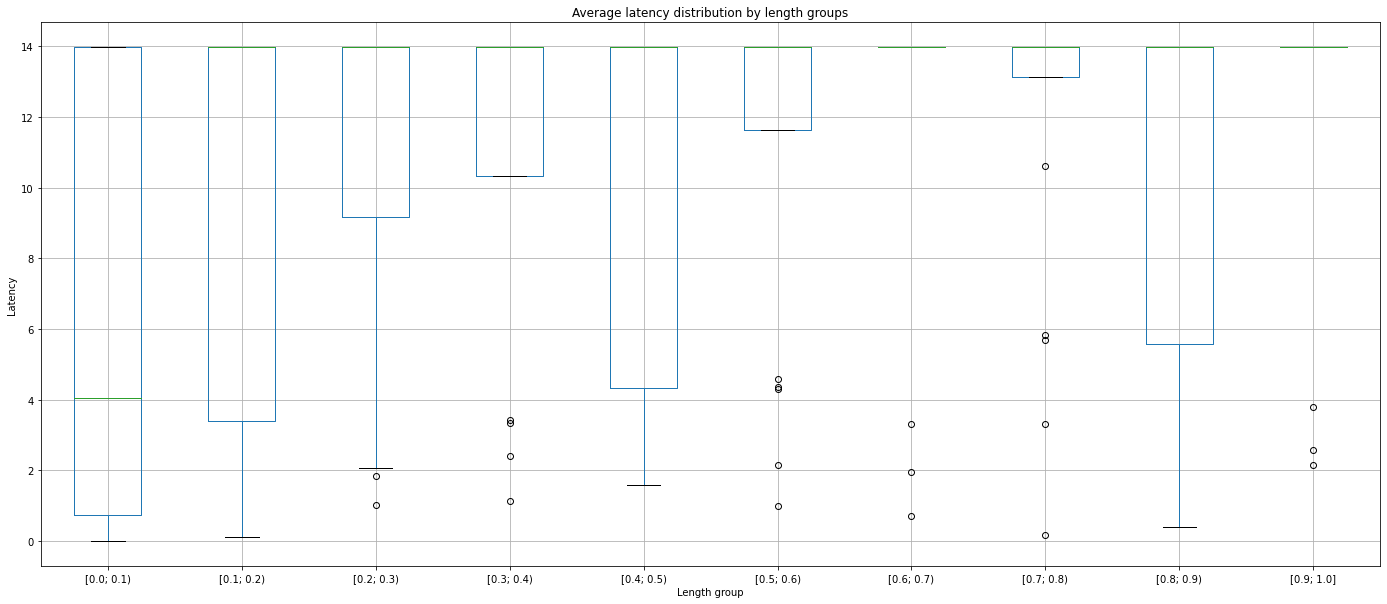

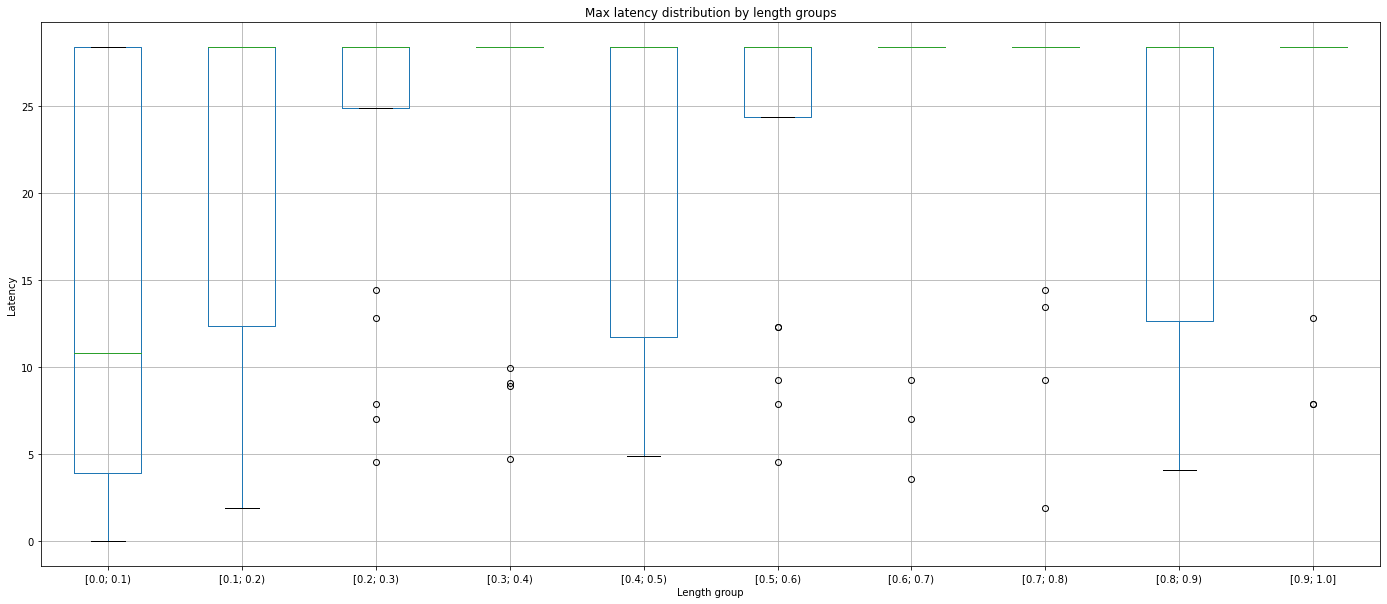

In [14]:
def plot_length_graphs():
    # Подсчитаем максимальные и средние задержки для каждого видео
    max_video_latencies = []
    avg_video_latencies = []
    for video in videos.iloc:
        max_video_latency = 0
        avg_video_latency = 0
        for node in nodes:
            cur_video_node = node_video_closest_server[node][video["video_id"]]
            cur_latency = fast_path_length[node][cur_video_node]
            if max_video_latency < cur_latency:
                max_video_latency = cur_latency
            avg_video_latency += cur_latency
        avg_video_latency /= len(nodes)

        max_video_latencies.append(max_video_latency)
        avg_video_latencies.append(avg_video_latency)

    videos["max_video_latency"] = max_video_latencies
    videos["avg_video_latency"] = avg_video_latencies

    # По новым колонкам оценим какова задержка для видео разной длины
    ax = plt.figure(figsize=(24,10)).gca()
    ax.set_title('Average latency distribution by length groups')
    ax.set_xlabel('Length group')
    ax.set_ylabel('Latency')
    videos.groupby("video_length_group").boxplot(column="avg_video_latency", subplots=False)
    ax.set_xticklabels([f"[{round(i / 10, 1)}; {round(i / 10 + 0.1, 1)})" for i in range(9)] + ["[0.9; 1.0]"])
    plt.show()

    ax = plt.figure(figsize=(24,10)).gca()
    ax.set_title('Max latency distribution by length groups')
    ax.set_xlabel('Length group')
    ax.set_ylabel('Latency')
    videos.groupby("video_length_group").boxplot(column="max_video_latency", subplots=False, figsize=(24,10))
    ax.set_xticklabels([f"[{round(i / 10, 1)}; {round(i / 10 + 0.1, 1)})" for i in range(9)] + ["[0.9; 1.0]"])
    plt.show()


plot_length_graphs()

Как можно видеть на данный момент нет различий в задержке между длинными и короткими видео.

Определим теперь новую колонку важности видео, используя длину и популярность. Поскольку более короткие видео важнее возведем длину в степень -1 и разделим на сумму, чтобы привести данную характеристику к такому же как у популярности масштабу.

Новая колонка это взвешенное среднее от длины и популярности, где веса образуются из заранее определенного коэффициента

In [15]:
videos["popularity_length"] =  1 / videos["video_length"]
videos["popularity_length"] = videos["popularity_length"] / videos["popularity_length"].sum()
videos["popularity_length"] = videos["popularity_length"] * LENGTH_POPULARITY_COEF + videos["popularity"] * (1 - LENGTH_POPULARITY_COEF)

Проведем размещение и оценим его

In [16]:
IMPORTANCE = "popularity_length"
reset_placement(IMPORTANCE)
place_videos_v1(IMPORTANCE)
second_placement = node_latency.copy()

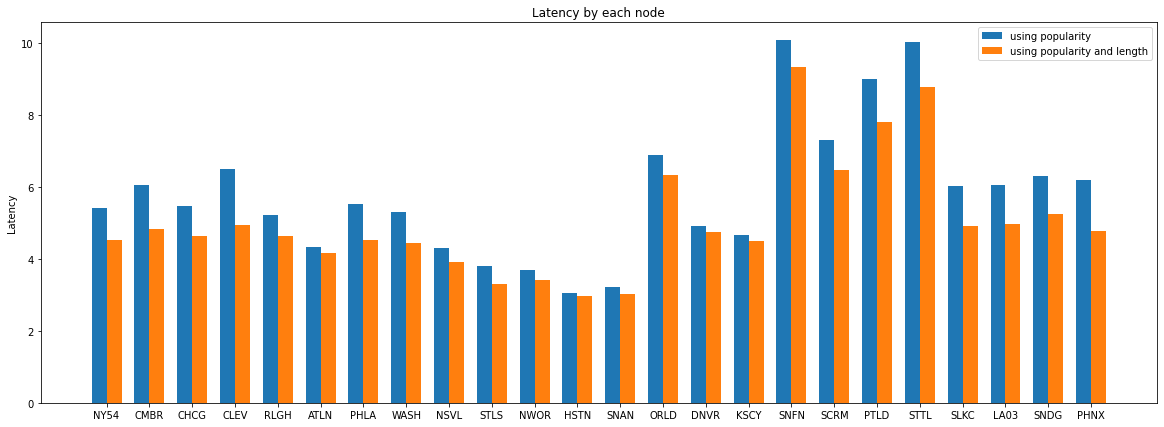

In [17]:
compare_placement(first_placement, second_placement, 'using popularity', 'using popularity and length')

Как можно заметить задержка уменьшилась, относительно размещения с использованием только популярности. Данный результат может показаться странным, поскольку в данном случае мы уменьшили важность популярности и начали также рассматривать длину видео, хотя сравниваемая задержка учитывается только с использованием популярности. Ответ на самом деле достаточно прост: более короткие видео весят меньше, а значит на узле поместится большее количество видео. Поскольку среди коротких видео достаточно много популярных видео возможность разместить их все улучшает задержку сильнее чем размещения нескольких больших популярных видео.

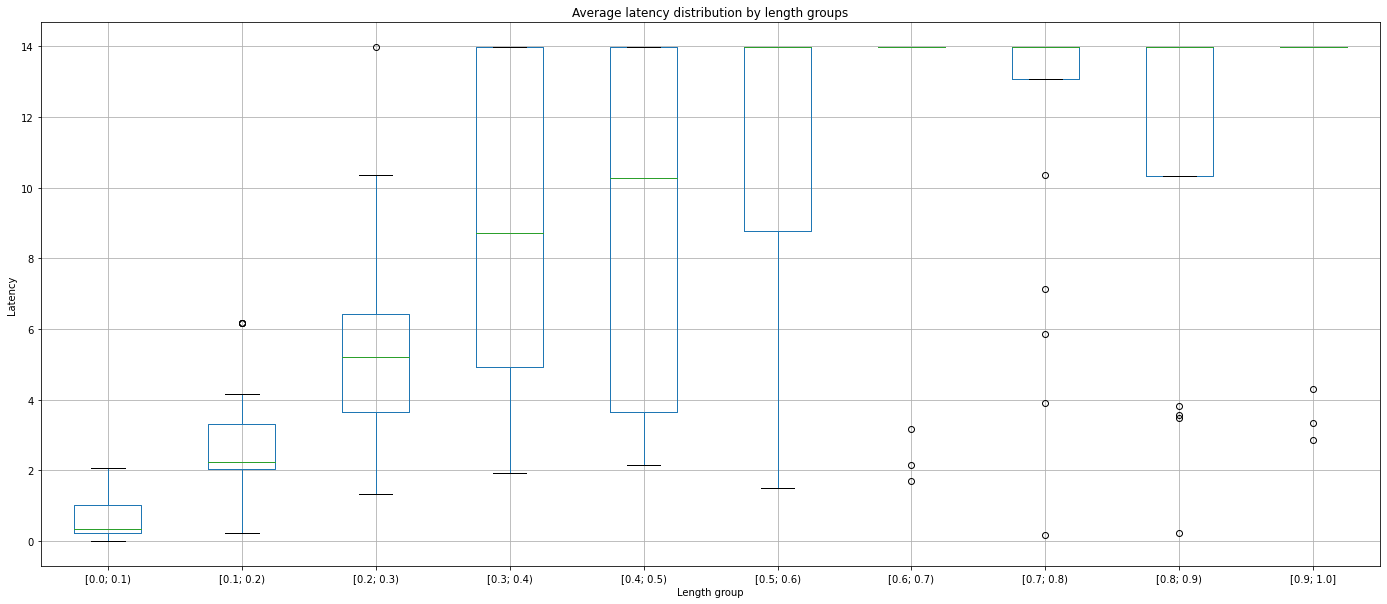

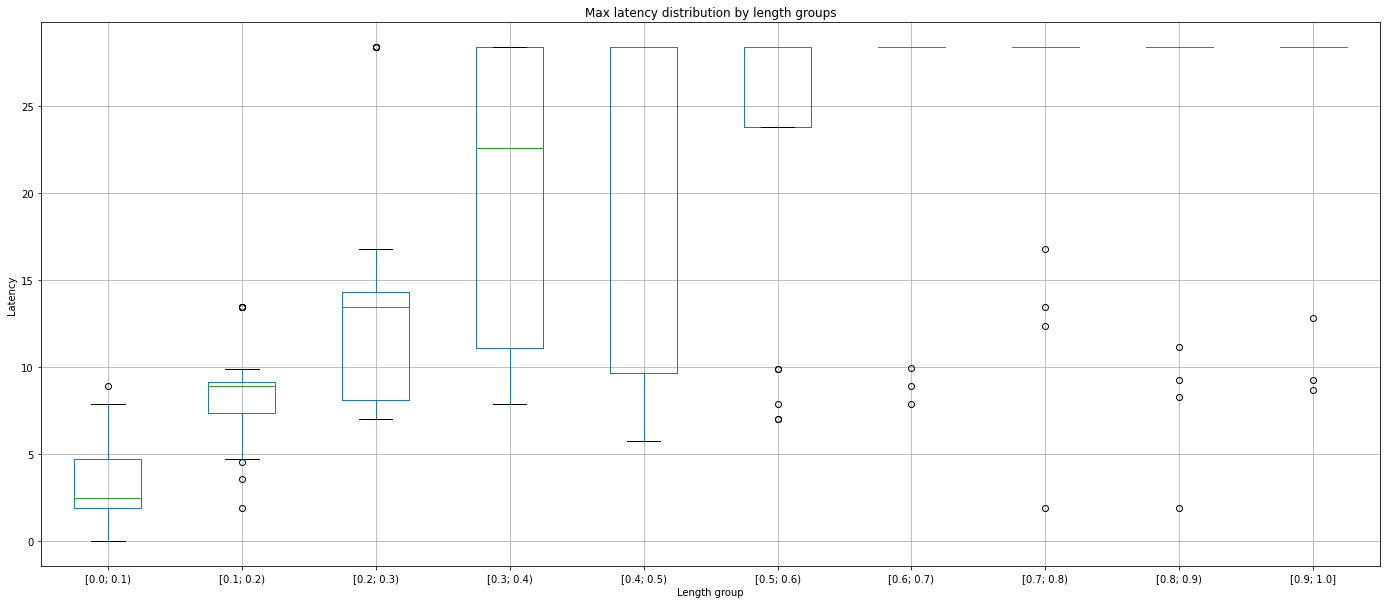

In [18]:
plot_length_graphs()

Теперь задержка к коротким видео гораздо меньше, чем к длинным

In [19]:
print(f"Видео, которые присутствуют только на оригинальном сервере: {count_videos_without_replicas()}/{videos.shape[0]}")

Видео, которые присутствуют только на оригинальном сервере: 108/200


А здесь можно видеть, что количество видео без реплик увеличилось относительно прошлого размещения, что означает что множество видео, которое участвовало в размещении значительно меньше. То есть выбирались преимущественно короткие видео

Попробуем теперь изменить способ выбора видео. Будем учитывать не только выгоду для выбранного узла, но также выгоду для остальных узлов.

In [20]:
def place_videos_v2(importance):
    global node_capacity, node_latency, node_with_space_latency, node_video_closest_server, node_videos
    while node_with_space_latency:
        # Выбираем узел с наибольшей задержкой
        target_node = max(node_with_space_latency, key=node_with_space_latency.get)

        # Убираем из поиска все видео размер которых превышает текущее свободное место на узле и которые уже есть на сервере
        target_videos = videos[(videos["video_size"] <= node_capacity[target_node]) & (~videos["video_id"].isin(node_videos[target_node]))]
        # Если нет видео которые можно разместить тогда убираем из рассмотрения данный узел
        if target_videos.shape[0] == 0:
            node_with_space_latency.pop(target_node)
            continue

        # Ищем видео, добавление которого на узел наилучшим образом улучшит задержку
        max_profit = 0
        target_video = None
        for video in target_videos.iloc:
            # Считаем выгоду учитывая все узлы, а не только выбранный
            sum_profit = 0
            for node in nodes:
                video_node = node_video_closest_server[node][video["video_id"]]
                profit = (fast_path_length[node][video_node] - fast_path_length[node][target_node]) * video[importance]
                if profit > 0:
                    sum_profit += profit
            if sum_profit > max_profit:
                max_profit = sum_profit
                target_video = video

        for node in nodes:
            # Определяем будет ли улучшение для узла от размещения видео на выбранном узле
            cur_video_node = node_video_closest_server[node][target_video["video_id"]]
            cur_latency = fast_path_length[node][cur_video_node]
            new_latency = fast_path_length[node][target_node]
            if cur_latency < new_latency:
                continue

            # Обновляем задержку и меняем узел, с которого данное видео будет запрашиваться
            node_latency[node] -= (cur_latency - new_latency) * target_video["popularity"]
            node_video_closest_server[node][target_video["video_id"]] = target_node
            if node in node_with_space_latency:
                node_with_space_latency[node] -= (cur_latency - new_latency) * target_video[importance]
        # Добавляем видео на узел и уменьшаем свободное место
        node_videos[target_node].append(target_video["video_id"])
        node_capacity[target_node] -= target_video["video_size"]

In [21]:
reset_placement(IMPORTANCE)
place_videos_v2(IMPORTANCE)
third_placement = node_latency.copy()

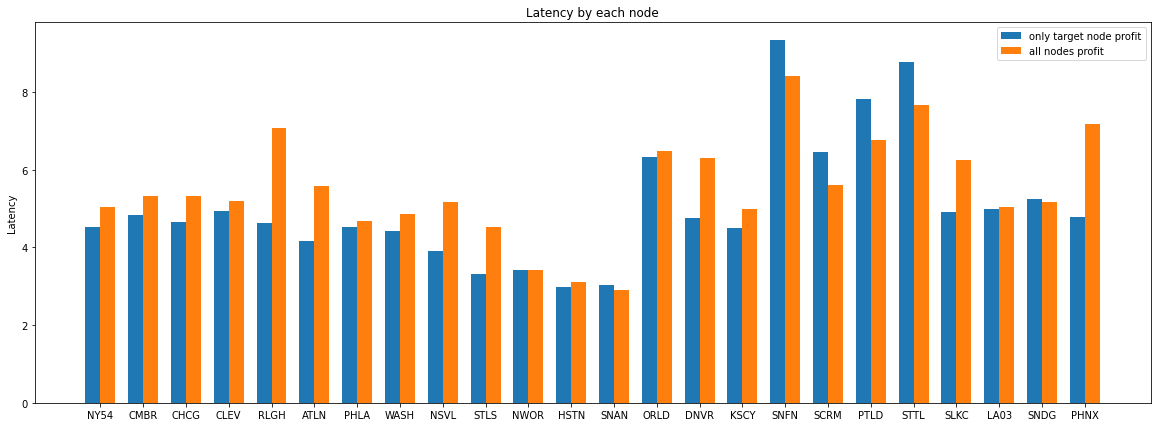

In [22]:
compare_placement(second_placement, third_placement, 'only target node profit', 'all nodes profit')

Задержка для данного способа в среднем не поменялась

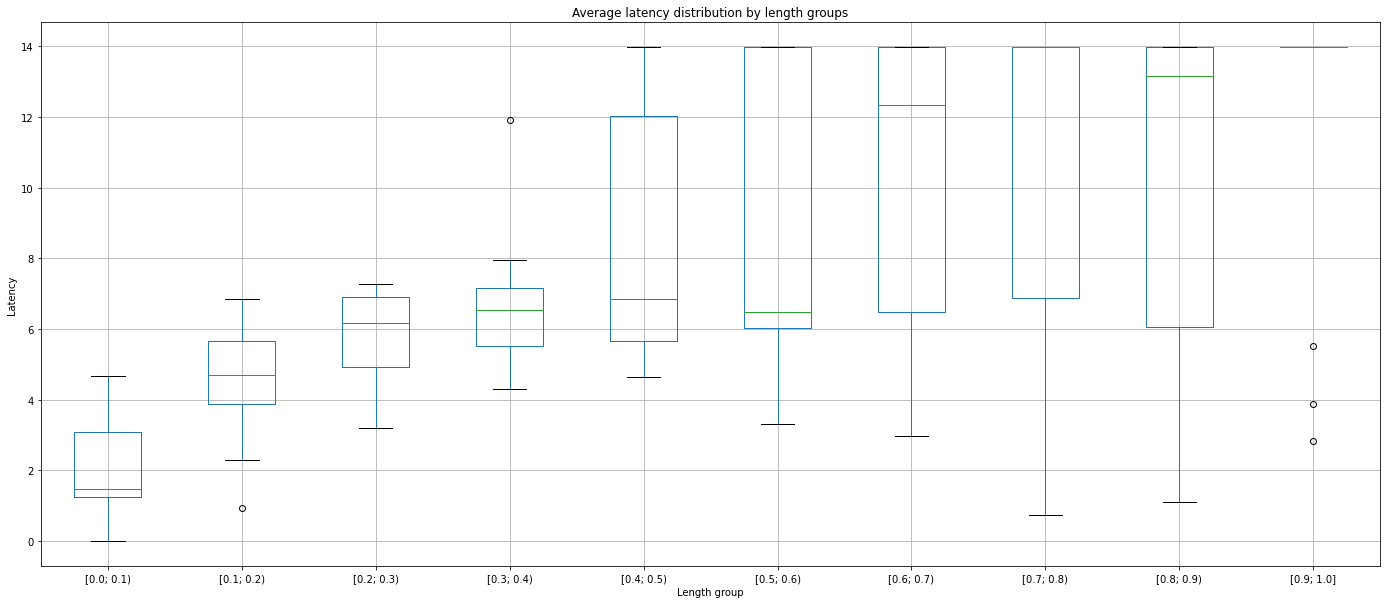

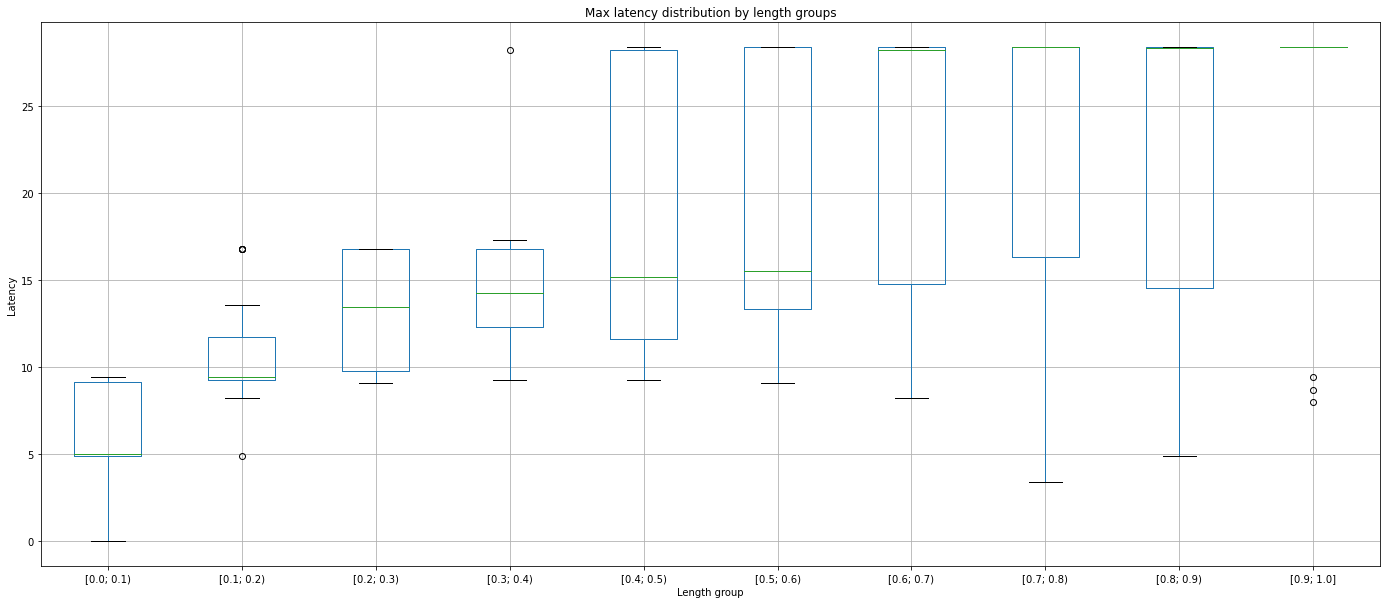

In [23]:
plot_length_graphs()

А вот задержка в зависимости от длины видео изменилась заметно. Появилась более выраженная зависимость, за счет того, что у большего количества групп улучшилась задержка

Далее оценим нагрузку на узлы. Будем считать ее следующим образом для каждого узла для каждого видео определяем путь через который данное видео пройдет при запросе. У каждого узла в данном пути увеличиваем нагрузку на величину популярности видео. Популярность можно считать корректным показателем нагрузки, потому что популярность является нормированным количеством запросов к видео.

In [24]:
node_load = {node: 0. for node in nodes}
# Оригинального сервера нет в списке nodes и он не участвует в размещении, однако запросы на него приходят наравне со всеми, поэтому ставим ему нагрузку в размере 1.0
node_load[ORIGIN_SERVER] = 1.0
for node in nodes:
    node_load[node] = 1.0
    for video in videos.iloc:
        load = video['popularity']
        for affected_node in fast_path[node][node_video_closest_server[node][video['video_id']]]:
            node_load[affected_node] += load

In [25]:
node_load

{'NY54': 2.666388288861553,
 'CMBR': 2.4207352261671184,
 'CHCG': 2.552211976519323,
 'CLEV': 2.8317914560263366,
 'RLGH': 2.1430322955414924,
 'ATLN': 2.430496383378988,
 'PHLA': 2.237840918303319,
 'WASH': 2.010451491185087,
 'NSVL': 2.117332475239732,
 'STLS': 2.030598290128455,
 'NWOR': 2.307662993516418,
 'HSTN': 2.0921844957069795,
 'SNAN': 2.1989753814747366,
 'ORLD': 2.0000000000000004,
 'DNVR': 2.2610580459529803,
 'KSCY': 2.0508619535497172,
 'SNFN': 3.999635021665199,
 'SCRM': 2.2472295707946226,
 'PTLD': 2.124039833537926,
 'STTL': 2.0295366972698594,
 'SLKC': 2.2268893848368974,
 'LA03': 2.8207083520893597,
 'SNDG': 2.2302233425434377,
 'PHNX': 2.0000000000000004,
 'DLLS': 4.56048609457849}

Как можно видеть нагрузка на узлы в среднем похожая, за исключением оригинального сервера (DLLS), поскольку много запросов перенаправляется в него